# Task 8 – Machine Learning Models (XGBoost)

This notebook rebuilds Task 8 from scratch, focusing on a single XGBoost model for hourly demand forecasting. 

Key goals:
- prepare a clean modelling dataset with aligned timestamps and numeric features
- train an XGBoost regressor with version-agnostic settings
- evaluate performance on a held-out validation week and export predictions/metrics
- generate academic-style figures and compare results with the best statistical model from Task 7

In [1]:
# AUDIT: Diagnostics & Version Checks
import pandas as pd
import numpy as np
import xgboost as xgb
import statsmodels
import plotly
import matplotlib

print("═" * 60)
print("PACKAGE VERSIONS")
print("═" * 60)
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"xgboost: {xgb.__version__}")
print(f"statsmodels: {statsmodels.__version__}")
print(f"plotly: {plotly.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print()

def show_columns(df, name="Dataset"):
    """Display column types and missing value percentages."""
    print(f"\n{'─' * 60}")
    print(f"{name.upper()} COLUMN SUMMARY")
    print(f"{'─' * 60}")
    print(f"{'Column':<30} {'Type':<15} {'% NA':>10}")
    print(f"{'─' * 60}")
    for col in df.columns:
        pct_na = 100 * df[col].isna().sum() / len(df)
        print(f"{col:<30} {str(df[col].dtype):<15} {pct_na:>9.2f}%")
    print(f"{'─' * 60}\n")

════════════════════════════════════════════════════════════
PACKAGE VERSIONS
════════════════════════════════════════════════════════════
pandas: 1.5.3
numpy: 1.23.5
xgboost: 3.0.5
statsmodels: 0.14.5
plotly: 6.3.0
matplotlib: 3.5.3



In [2]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path.cwd().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.modeling_ml import (
    set_seed,
    build_ml_dataset,
    train_xgboost,
    predict_xgboost,
    evaluate_forecast,
    align_by_index,
)

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

TARGET = "Demand"
REPORTS_DIR = ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"

for path in (FIGURES_DIR, TABLES_DIR):
    path.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid")
ENERGY_COLORS = {
    "actual": "#1f77b4",
    "xgboost": "#FFA500",
    "stat": "#2ca02c",
}


def save_figure(fig: plt.Figure, name: str, width: float = 10, height: float = 5, dpi: int = 300) -> None:
    fig.set_size_inches(width, height)
    png_path = FIGURES_DIR / f"task8_{name}.png"
    pdf_path = FIGURES_DIR / f"task8_{name}.pdf"
    fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure: {png_path.name} and {pdf_path.name}")

In [3]:
DATA_PATH = ROOT / "data" / "processed" / "task5_features.parquet"
print(f"Loading processed dataset from: {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
if "timestamp" not in df.columns:
    df = df.reset_index().rename(columns={"index": "timestamp"})

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

if df["timestamp"].dt.tz is not None:
    df["timestamp"] = df["timestamp"].dt.tz_convert(None)

print(f"Dataset shape: {df.shape}")
print(f"Time span: {df['timestamp'].min()} → {df['timestamp'].max()}")

# AUDIT: Show column diagnostics
show_columns(df, "Task 5 Features")

df.head()

Loading processed dataset from: /Users/samuel/EDS/Energy_Data_Science/data/processed/task5_features.parquet
Dataset shape: (8759, 17)
Time span: 2013-07-01 00:00:00 → 2014-06-30 23:00:00

────────────────────────────────────────────────────────────
TASK 5 FEATURES COLUMN SUMMARY
────────────────────────────────────────────────────────────
Column                         Type                  % NA
────────────────────────────────────────────────────────────
timestamp                      datetime64[ns]       0.00%
Demand                         float64              0.00%
hour_sin                       float64              0.00%
hour_cos                       float64              0.00%
is_weekend                     int64                0.00%
cooling_degree                 float64              0.00%
heating_degree                 float64              0.00%
temp_irradiance_interaction    float64             81.00%
Temperature                    float64              0.00%
Pressure (hPa)    

,timestamp,Demand,hour_sin,hour_cos,is_weekend,cooling_degree,heating_degree,temp_irradiance_interaction,Temperature,Pressure (hPa),Cloud_cover (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),Price
0,2013-07-01 00:00:00,0.27,0.000000,1.000000,0,0.0,4.5,NaN,13.5,1011.3,4,10.5,NaN,0,0,0.0,0.01605
1,2013-07-01 01:00:00,0.23,0.258819,0.965926,0,0.0,4.8,NaN,13.2,1010.8,27,11.9,NaN,0,0,0.0,0.00095
2,2013-07-01 02:00:00,0.26,0.500000,0.866025,0,0.0,4.9,NaN,13.1,1010.3,33,11.6,NaN,0,0,0.0,0.00060
3,2013-07-01 03:00:00,0.28,0.707107,0.707107,0,0.0,5.0,NaN,13.0,1010.3,28,11.2,NaN,2,7,30.1,0.00046
4,2013-07-01 04:00:00,0.29,0.866025,0.500000,0,0.0,4.2,NaN,13.8,1010.2,16,11.7,NaN,30,31,252.0,0.00046


In [4]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
FEATURE_COLS = [col for col in numeric_columns if col.lower() != TARGET.lower()]

print(f"Selected {len(FEATURE_COLS)} numeric feature columns.")
FEATURE_COLS

Selected 15 numeric feature columns.


['hour_sin',
 'hour_cos',
 'is_weekend',
 'cooling_degree',
 'heating_degree',
 'temp_irradiance_interaction',
 'Temperature',
 'Pressure (hPa)',
 'Cloud_cover (%)',
 'Wind_speed_10m (km/h)',
 'Shortwave_radiation (W/m²)',
 'direct_radiation (W/m²)',
 'diffuse_radiation (W/m²)',
 'direct_normal_irradiance (W/m²)',
 'Price']

In [5]:
VALIDATION_DAYS = 7
validation_start = df["timestamp"].max() - pd.Timedelta(days=VALIDATION_DAYS)
train_df = df[df["timestamp"] < validation_start].copy()
val_df = df[df["timestamp"] >= validation_start].copy()

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Validation window: {val_df['timestamp'].min()} → {val_df['timestamp'].max()}")

Training samples: 8590
Validation samples: 169
Validation window: 2014-06-23 23:00:00 → 2014-06-30 23:00:00


In [6]:
X_train, y_train, idx_train = build_ml_dataset(train_df, target=TARGET, feature_cols=FEATURE_COLS)
X_val, y_val, idx_val = build_ml_dataset(val_df, target=TARGET, feature_cols=FEATURE_COLS)

# AUDIT: Strict length assertions after each build
assert len(X_train) == len(y_train) == len(idx_train), f"Train length mismatch: X={len(X_train)}, y={len(y_train)}, idx={len(idx_train)}"
assert len(X_val) == len(y_val) == len(idx_val), f"Val length mismatch: X={len(X_val)}, y={len(y_val)}, idx={len(idx_val)}"

print(f"✓ Training matrix shape: {X_train.shape}, target: {y_train.shape}, index: {len(idx_train)}")
print(f"✓ Validation matrix shape: {X_val.shape}, target: {y_val.shape}, index: {len(idx_val)}")

⚠️  Dropped 6953 rows with NA values in features/target
⚠️  Dropped 142 rows with NA values in features/target
✓ Training matrix shape: (1637, 15), target: (1637,), index: 1637
✓ Validation matrix shape: (27, 15), target: (27,), index: 27


In [7]:
# AUDIT: XGBoost params - NO fragile fit kwargs (callbacks/verbose/early_stopping)
# Set eval_metric on model only, not in fit()
xgb_params = {
    "n_estimators": 600,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "gamma": 0.0,
    "eval_metric": "rmse",  # AUDIT: Set on model, not fit
}

model, eval_history = train_xgboost(
    X_train,
    y_train,
    X_val=X_val,
    y_val=y_val,
    params=xgb_params,
    seed=RANDOM_SEED,
)

print(model)
print(f"Evaluation history available: {bool(eval_history)}")

[0]	validation_0-rmse:0.34333	validation_1-rmse:0.25090
[1]	validation_0-rmse:0.33850	validation_1-rmse:0.25256
[2]	validation_0-rmse:0.33341	validation_1-rmse:0.25235
[1]	validation_0-rmse:0.33850	validation_1-rmse:0.25256
[2]	validation_0-rmse:0.33341	validation_1-rmse:0.25235
[3]	validation_0-rmse:0.32873	validation_1-rmse:0.25016
[4]	validation_0-rmse:0.32400	validation_1-rmse:0.25045
[3]	validation_0-rmse:0.32873	validation_1-rmse:0.25016
[4]	validation_0-rmse:0.32400	validation_1-rmse:0.25045
[5]	validation_0-rmse:0.31943	validation_1-rmse:0.25020
[6]	validation_0-rmse:0.31551	validation_1-rmse:0.25225
[5]	validation_0-rmse:0.31943	validation_1-rmse:0.25020
[6]	validation_0-rmse:0.31551	validation_1-rmse:0.25225
[7]	validation_0-rmse:0.31213	validation_1-rmse:0.25249
[7]	validation_0-rmse:0.31213	validation_1-rmse:0.25249
[8]	validation_0-rmse:0.30904	validation_1-rmse:0.25324
[9]	validation_0-rmse:0.30472	validation_1-rmse:0.25293
[8]	validation_0-rmse:0.30904	validation_1-rmse:

In [8]:
y_pred = predict_xgboost(model, X_val)

# AUDIT: Use align_by_index helper to ensure timestamp alignment
common_idx, s_true, s_pred = align_by_index(y_val, y_pred, idx_val, idx_val)
print(f"✓ Aligned {len(common_idx)} timestamps for evaluation")

# AUDIT: Save predictions CSV with proper alignment
ml_split_predictions_df = pd.DataFrame(
    {
        "timestamp": common_idx,
        "Actual": s_true.values,
        "XGBoost": s_pred.values,
    }
)
ml_split_predictions_path = TABLES_DIR / "ml_split_predictions.csv"
ml_split_predictions_df.to_csv(ml_split_predictions_path, index=False)
print(f"✓ Saved predictions to {ml_split_predictions_path}")

# AUDIT: Calculate metrics with aligned series
metrics = evaluate_forecast(s_true.values, s_pred.values)
ml_split_metrics_df = pd.DataFrame(
    [{**metrics, "model_name": "XGBoost", "evaluation": "Whole-train split"}]
)
ml_split_metrics_path = TABLES_DIR / "ml_split_metrics.csv"
ml_split_metrics_df.to_csv(ml_split_metrics_path, index=False)
print(f"✓ Saved metrics to {ml_split_metrics_path}")

ml_split_metrics_df

✓ Aligned 27 timestamps for evaluation
✓ Saved predictions to /Users/samuel/EDS/Energy_Data_Science/reports/tables/ml_split_predictions.csv
✓ Saved metrics to /Users/samuel/EDS/Energy_Data_Science/reports/tables/ml_split_metrics.csv


,MAE,RMSE,nRMSE,model_name,evaluation
0,0.214823,0.271483,0.298333,XGBoost,Whole-train split


Saved figure: task8_forecast_overlay.png and task8_forecast_overlay.pdf


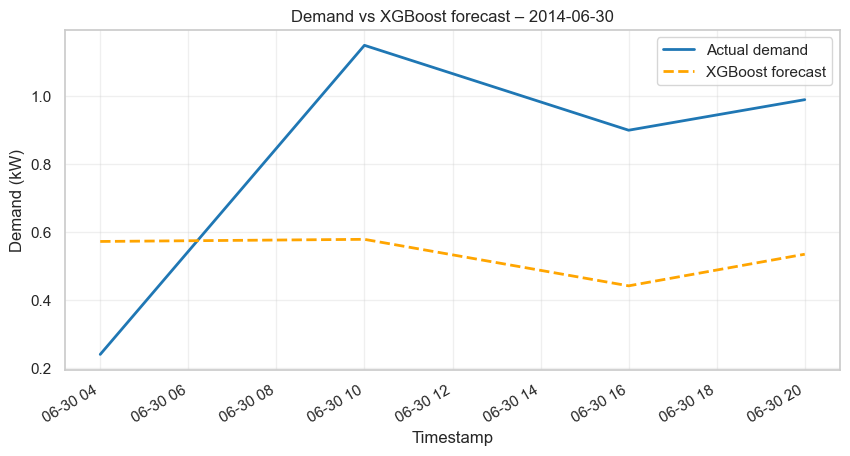

In [9]:
# AUDIT: Plot with white background
forecast_df = pd.DataFrame({"Actual": s_true, "XGBoost": s_pred})
forecast_df.index = forecast_df.index.tz_localize(None) if getattr(forecast_df.index, "tz", None) else forecast_df.index

selected_day = forecast_df.index.normalize().unique()[-1]
day_mask = forecast_df.index.normalize() == selected_day
day_df = forecast_df.loc[day_mask]

fig, ax = plt.subplots(facecolor='white')  # AUDIT: White background
ax.set_facecolor('white')
ax.plot(day_df.index, day_df["Actual"], label="Actual demand", color=ENERGY_COLORS["actual"], linewidth=2)
ax.plot(day_df.index, day_df["XGBoost"], label="XGBoost forecast", color=ENERGY_COLORS["xgboost"], linewidth=2, linestyle="--")
ax.set_title(f"Demand vs XGBoost forecast – {selected_day.date()}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Demand (kW)")
ax.legend()
ax.grid(alpha=0.3)
fig.autofmt_xdate()

save_figure(fig, "forecast_overlay")
plt.show()

Saved figure: task8_metrics_summary.png and task8_metrics_summary.pdf


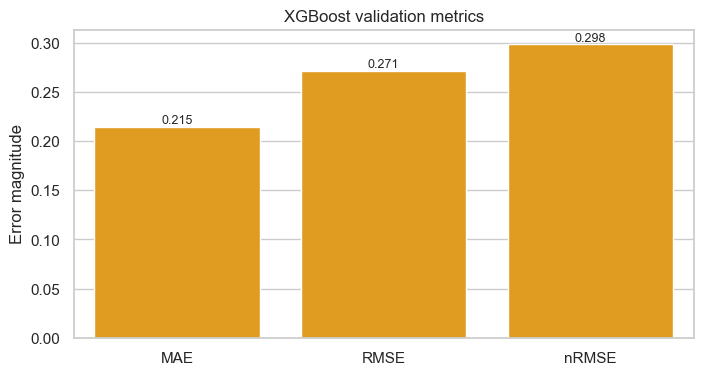

In [10]:
# AUDIT: Metrics bar chart with white background
metrics_long = ml_split_metrics_df.melt(
    id_vars=["model_name", "evaluation"],
    value_vars=["MAE", "RMSE", "nRMSE"],
    var_name="Metric",
    value_name="Value",
)

fig, ax = plt.subplots(facecolor='white')
ax.set_facecolor('white')
sns.barplot(data=metrics_long, x="Metric", y="Value", color=ENERGY_COLORS["xgboost"], ax=ax)
ax.set_title("XGBoost validation metrics")
ax.set_xlabel("")
ax.set_ylabel("Error magnitude")
for bar in ax.patches:
    ax.annotate(f"{bar.get_height():.3f}", (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center", va="bottom", fontsize=9)

save_figure(fig, "metrics_summary", width=8, height=4)
plt.show()

Saved figure: task8_feature_importance.png and task8_feature_importance.pdf


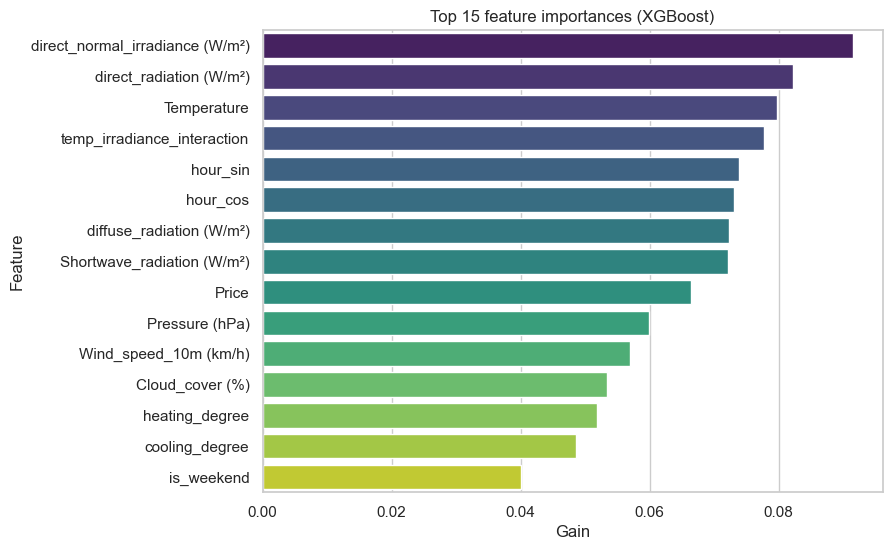

✓ Saved feature importances to /Users/samuel/EDS/Energy_Data_Science/reports/tables/ml_feature_importance.csv


In [11]:
# AUDIT: Feature importance with white background
feature_importances = pd.Series(model.feature_importances_, index=FEATURE_COLS)
top_features = feature_importances.sort_values(ascending=False).head(15)

fig, ax = plt.subplots(facecolor='white')
ax.set_facecolor('white')
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis", ax=ax)
ax.set_title("Top 15 feature importances (XGBoost)")
ax.set_xlabel("Gain")
ax.set_ylabel("Feature")

save_figure(fig, "feature_importance", width=8, height=6)
plt.show()

top_features_df = top_features.reset_index()
top_features_df.columns = ["feature", "importance"]
top_features_path = TABLES_DIR / "ml_feature_importance.csv"
top_features_df.to_csv(top_features_path, index=False)
print(f"✓ Saved feature importances to {top_features_path}")

In [12]:
comparison_rows = []
stat_predictions_path = TABLES_DIR / "stats_single_split_predictions.csv"

if stat_predictions_path.exists():
    stat_df = pd.read_csv(stat_predictions_path, parse_dates=["timestamp"])
    stat_df = stat_df.sort_values(["model_name", "timestamp"])

    for model_name, group in stat_df.groupby("model_name"):
        group_idx = pd.Index(group["timestamp"], name="timestamp")
        group_true = pd.Series(group["y_true"].astype(float).values, index=group_idx)
        group_pred = pd.Series(group["y_pred"].astype(float).values, index=group_idx)
        overlap = group_idx.intersection(common_idx)
        if overlap.empty:
            continue
        aligned_true = group_true.loc[overlap]
        aligned_pred = group_pred.loc[overlap]
        stats_metrics = evaluate_forecast(aligned_true.values, aligned_pred.values)
        comparison_rows.append({
            **stats_metrics,
            "model_name": model_name,
            "evaluation": "Whole-train split (statistical)",
        })

    comparison_rows.append({
        **metrics,
        "model_name": "XGBoost",
        "evaluation": "Whole-train split (ML)",
    })

    if comparison_rows:
        comparison_df = pd.DataFrame(comparison_rows)
        comparison_path = TABLES_DIR / "best_stat_vs_ml_metrics.csv"
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Saved comparison metrics to {comparison_path}")
        comparison_df
    else:
        print("No overlapping timestamps between statistical and ML predictions; comparison skipped.")
else:
    print("Statistical prediction file not found; skipping comparison.")

Saved comparison metrics to /Users/samuel/EDS/Energy_Data_Science/reports/tables/best_stat_vs_ml_metrics.csv
